# House Price data exploration

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

This notebook gives an analysis of the relationship between the price and the variables.


In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from scipy import stats

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
submission = pd.read_csv("../input/sample_submission.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


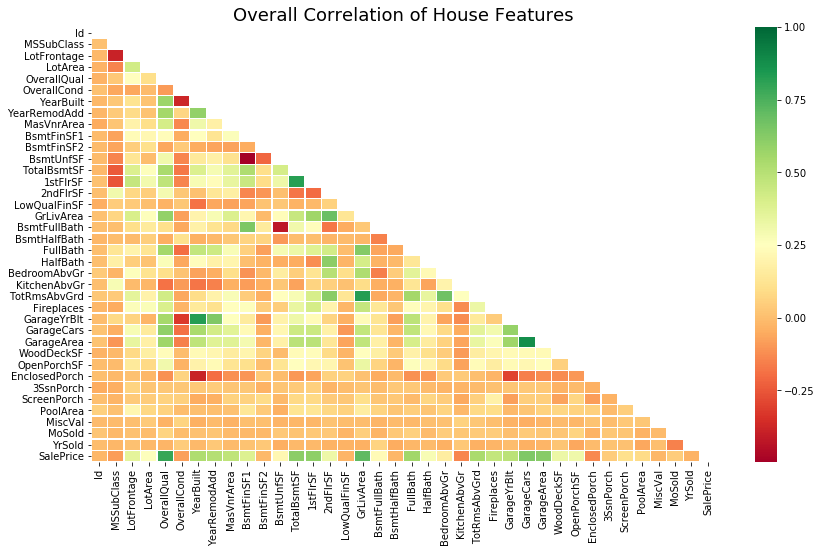

In [4]:
# Initiate correlation matrix
corr = train.corr()
# Set-up mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set-up figure
plt.figure(figsize=(14, 8))
# Title
plt.title('Overall Correlation of House Features', fontsize=18)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':100})
plt.show()

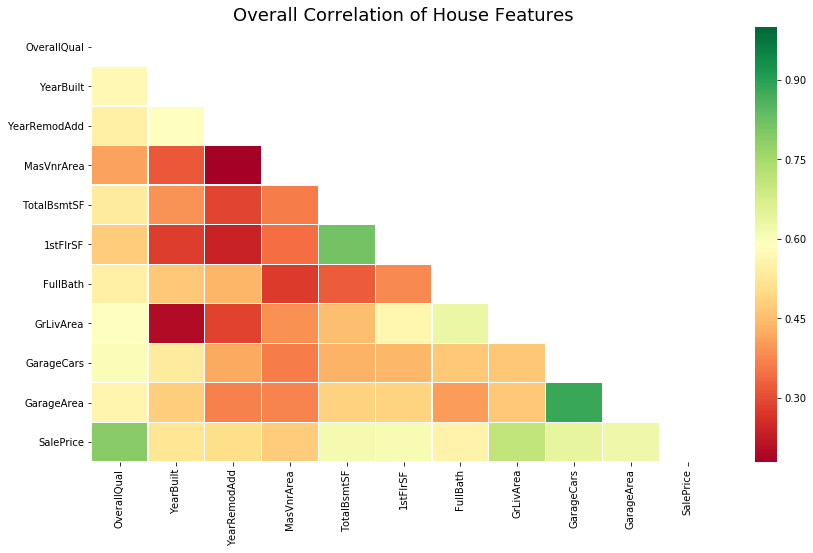

In [5]:
# Initiate correlation matrix
corr = train[["OverallQual", 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'GrLivArea', 'GarageCars', "GarageArea", "SalePrice"]].corr()
# Set-up mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set-up figure
plt.figure(figsize=(14, 8))
# Title
plt.title('Overall Correlation of House Features', fontsize=18)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':100})
plt.show()

In [6]:
# Join all data into one file
ntrain = train.shape[0]
ntest = test.shape[0]

# Creating y_train variable; we'll need this when modelling, but not before
y_train = train['SalePrice'].values

# Saving the house ID's ready for our submission file at the very end
houseId = test['Id']

# Create a new all-encompassing dataset
data = pd.concat((train, test))

# Printing overall data shape
print("data size is: {}".format(data.shape))

data size is: (2919, 81)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


In [7]:
data.count()

1stFlrSF         2919
2ndFlrSF         2919
3SsnPorch        2919
Alley             198
BedroomAbvGr     2919
BldgType         2919
BsmtCond         2837
BsmtExposure     2837
BsmtFinSF1       2918
BsmtFinSF2       2918
BsmtFinType1     2840
BsmtFinType2     2839
BsmtFullBath     2917
BsmtHalfBath     2917
BsmtQual         2838
BsmtUnfSF        2918
CentralAir       2919
Condition1       2919
Condition2       2919
Electrical       2918
EnclosedPorch    2919
ExterCond        2919
ExterQual        2919
Exterior1st      2918
Exterior2nd      2918
Fence             571
FireplaceQu      1499
Fireplaces       2919
Foundation       2919
FullBath         2919
                 ... 
LotShape         2919
LowQualFinSF     2919
MSSubClass       2919
MSZoning         2915
MasVnrArea       2896
MasVnrType       2895
MiscFeature       105
MiscVal          2919
MoSold           2919
Neighborhood     2919
OpenPorchSF      2919
OverallCond      2919
OverallQual      2919
PavedDrive       2919
PoolArea  

In [8]:
data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,Id,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
count,2919.000000,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,2917.000000,2917.000000,2918.000000,2919.000000,2919.000000,2919.000000,2918.000000,2918.000000,2760.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2896.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000,2919.000000,2919.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,1159.581706,336.483727,2.602261,2.860226,441.423235,49.582248,0.429894,0.061364,560.772104,23.098321,0.597122,1.568003,472.874572,1.766621,1978.113406,1500.759849,0.380267,1460.000000,1.044536,10168.114080,69.305795,4.694416,57.137718,102.201312,50.825968,6.213087,47.486811,5.564577,6.089072,2.251799,180921.195890,16.062350,6.451524,1051.777587,93.709832,1971.312778,1984.264474,2007.792737
std,392.362079,428.701456,25.188169,0.822693,455.610826,169.205611,0.524736,0.245687,439.543659,64.244246,0.646129,0.552969,215.394815,0.761624,25.574285,506.051045,0.502872,842.787043,0.214462,7886.996359,23.344905,46.396825,42.517628,179.334253,567.402211,2.714762,67.575493,1.113131,1.409947,35.663946,79442.502883,56.184365,1.569379,440.766258,126.526589,30.291442,20.894344,1.314964
min,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,334.000000,0.000000,1.000000,0.000000,1300.000000,21.000000,0.000000,20.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,34900.000000,0.000000,2.000000,0.000000,0.000000,1872.000000,1950.000000,2006.000000
25%,876.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,220.000000,0.000000,0.000000,1.000000,320.000000,1.000000,1960.000000,1126.000000,0.000000,730.500000,1.000000,7478.000000,59.000000,0.000000,20.000000,0.000000,0.000000,4.000000,0.000000,5.000000,5.000000,0.000000,129975.000000,0.000000,5.000000,793.000000,0.000000,1953.500000,1965.000000,2007.000000
50%,1082.000000,0.000000,0.000000,3.000000,368.500000,0.000000,0.000000,0.000000,467.000000,0.000000,1.000000,2.000000,480.000000,2.000000,1979.000000,1444.000000,0.000000,1460.000000,1.000000,9453.000000,68.000000,0.000000,50.000000,0.000000,0.000000,6.000000,26.000000,5.000000,6.000000,0.000000,163000.000000,0.000000,6.000000,989.500000,0.000000,1973.000000,1993.000000,2008.000000
75%,1387.500000,704.000000,0.000000,3.000000,733.000000,0.000000,1.000000,0.000000,805.500000,0.000000,1.000000,2.000000,576.000000,2.000000,2002.000000,1743.500000,1.000000,2189.500000,1.000000,11570.000000,80.000000,0.000000,70.000000,164.000000,0.000000,8.000000,70.000000,6.000000,7.000000,0.000000,214000.000000,0.000000,7.000000,1302.000000,168.000000,2001.000000,2004.000000,2009.000000
max,5095.000000,2065.000000,508.000000,8.000000,5644.000000,1526.000000,3.000000,2.000000,2336.000000,1012.000000,4.000000,4.000000,1488.000000,5.000000,2207.000000,5642.000000,2.000000,2919.000000,3.000000,215245.000000,313.000000,1064.000000,190.000000,1600.000000,17000.000000,12.000000,742.000000,9.000000,10.000000,800.000000,755000.000000,576.000000,15.000000,6110.000000,1424.000000,2010.000000,2010.000000,2010.000000


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


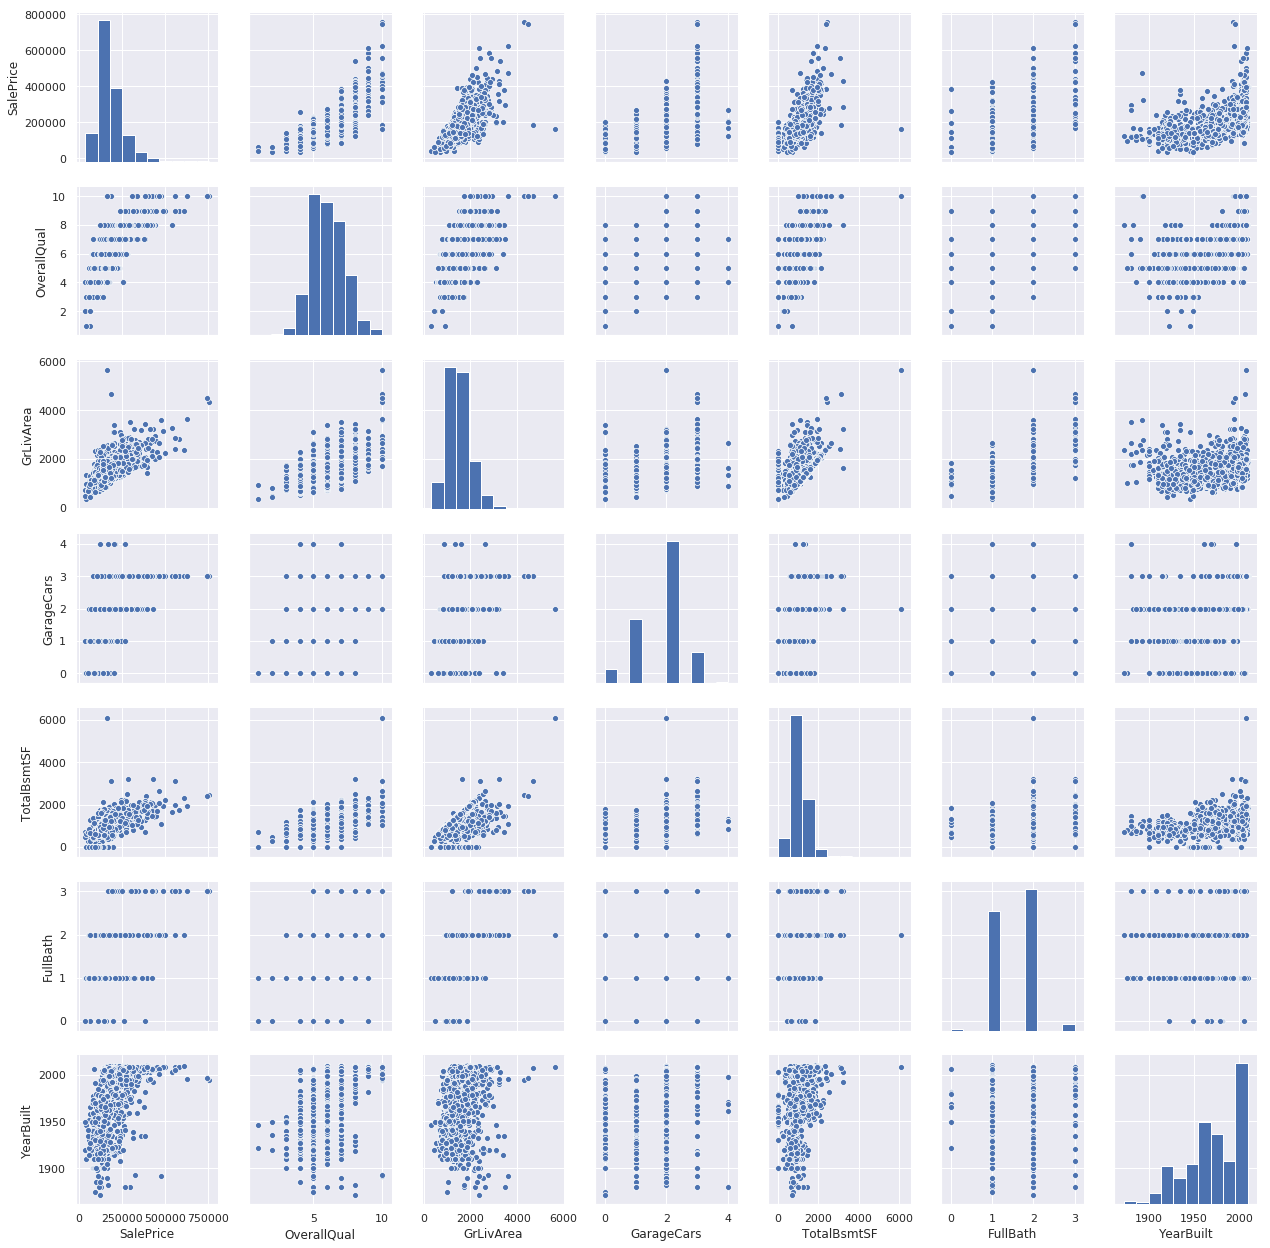

In [9]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

In [10]:
train[["OverallQual", 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'GrLivArea', 'GarageCars', "GarageArea", "SalePrice"]].count()

OverallQual     1460
YearBuilt       1460
YearRemodAdd    1460
MasVnrArea      1452
TotalBsmtSF     1460
1stFlrSF        1460
FullBath        1460
GrLivArea       1460
GarageCars      1460
GarageArea      1460
SalePrice       1460
dtype: int64

In [11]:
#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = round(train.isnull().sum()/train.isnull().count()*100, 2).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageCond,81,5.55
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


In [12]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


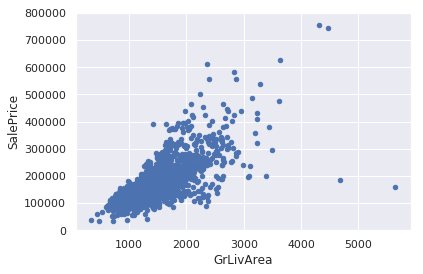

In [14]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [16]:
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


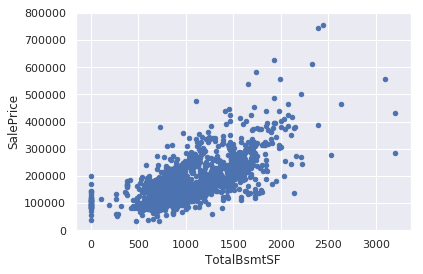

In [17]:
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


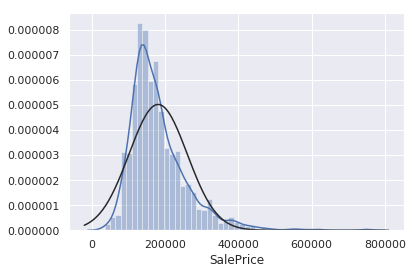

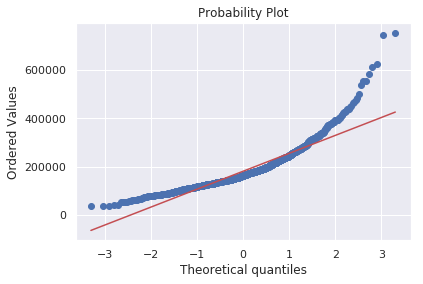

In [22]:
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [23]:
train['GrLivArea'] = np.log(train['GrLivArea'])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


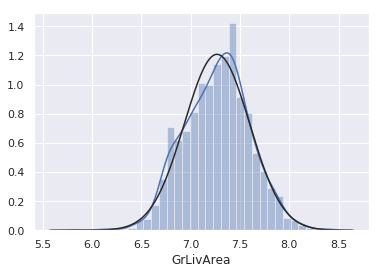

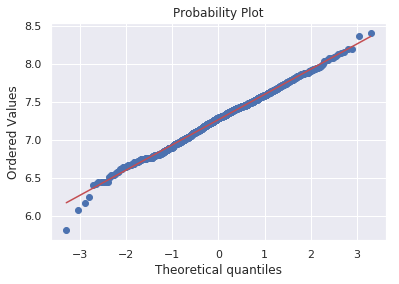

In [24]:
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


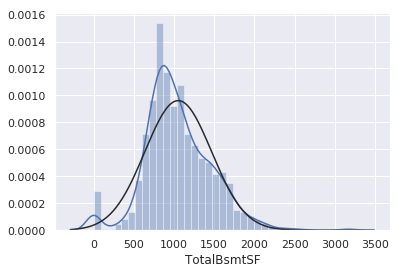

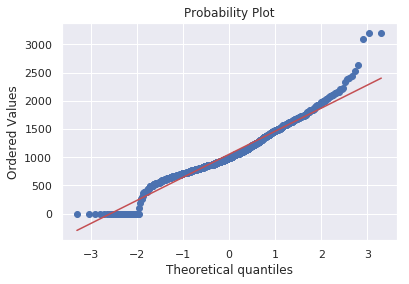

In [25]:
#histogram and normal probability plot
sns.distplot(train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

In [26]:
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBsmt'] = 0 
train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1

In [27]:
train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


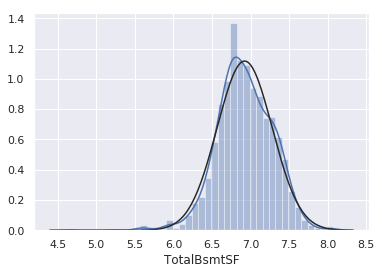

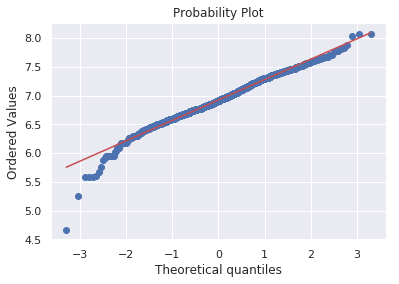

In [28]:
sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

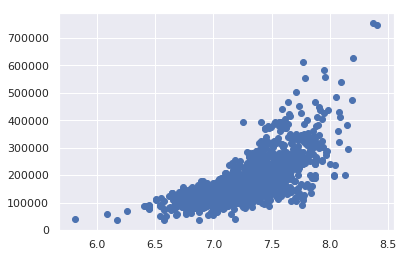

In [29]:
#scatter plot
plt.scatter(train['GrLivArea'], train['SalePrice']);

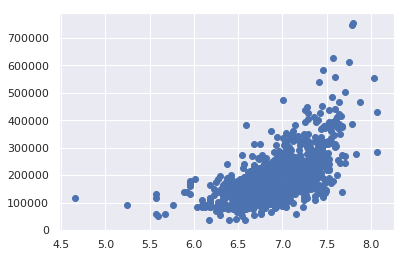

In [30]:
#scatter plot
plt.scatter(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], train[train['TotalBsmtSF']>0]['SalePrice']);